<a href="https://colab.research.google.com/github/thecodemancer/study-with-me/blob/main/apache-beam/late_data_and_triggers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install apache_beam
#!pip install ipython~=7.9.0
#!pip install ipykernel~=5.3.4
!pip install apache-beam[interactive]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.5/515.5 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 KB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.3/793.3 KB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.7/186.7 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 KB 20.4 MB/s eta 0:00:00
  Preparing me

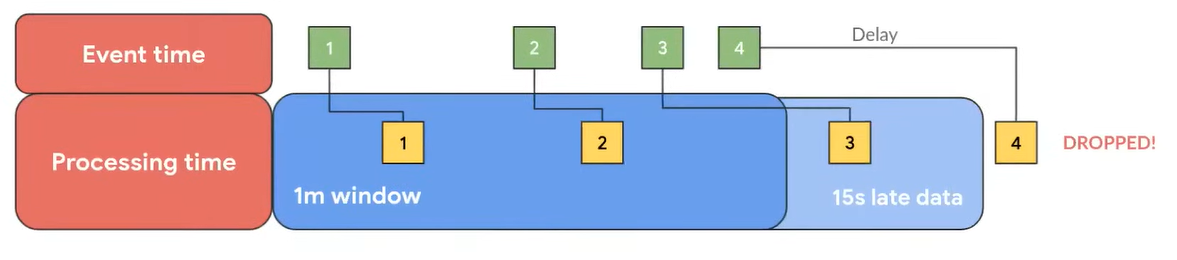

To mimic data arriving late to our pipeline, we are going to use `TestStream`. It allow us to advance watermark and processing time so we can add elements whenever we want.

In [1]:
import apache_beam as beam

from apache_beam.transforms.window import TimestampedValue, FixedWindows, SlidingWindows, Sessions, GlobalWindow
from apache_beam.runners.interactive.interactive_runner import InteractiveRunner 

import apache_beam.runners.interactive.interactive_beam as ib
from apache_beam.options.pipeline_options import PipelineOptions, StandardOptions
from apache_beam.testing.test_pipeline import TestPipeline
from apache_beam.testing.test_stream import TestStream

In [2]:
from apache_beam import Create, Map, ParDo, GroupByKey
from apache_beam import WindowInto, window


In [3]:
def get_stream_late():
  stream_late = (
      TestStream()
      .advance_watermark_to(10)
      .advance_processing_time(10)
      .add_elements([
          beam.window.TimestampedValue("1-in-time",timestamp=7) #event time=7
          ])
    .advance_watermark_to(40)
    .advance_processing_time(40)
    .add_elements([
        beam.window.TimestampedValue("2-in-time",timestamp=20) #event time=20
        ])
    .advance_watermark_to(65)
    .advance_processing_time(65)
    .add_elements([
        beam.window.TimestampedValue("3-late-allowed",timestamp=40)
        ])
    .advance_watermark_to(80)
    .advance_processing_time(80)
    .add_elements([
        beam.window.TimestampedValue("4-late-dropped",timestamp=50)
        ])  
    .advance_watermark_to_infinity()
    )

  return stream_late

Late Data

Let's now use the stream to see how we can handle late data


In [4]:
#options = PipelineOptions(streaming=True)
pipeline_options = PipelineOptions()
pipeline_options.view_as(StandardOptions).streaming = True

In [5]:
with TestPipeline(options=pipeline_options) as p:
  stream_late = get_stream_late()
  pc1 = (p | stream_late
            | beam.Map(lambda x: ("key",x))
            | beam.WindowInto(beam.window.FixedWindows(60)
              ,allowed_lateness=19)
            | beam.GroupByKey()
            | beam.Map(lambda x: print(x))
        )

('key', ['1-in-time', '2-in-time'])
('key', ['3-late-allowed'])


In [6]:
with TestPipeline(options=pipeline_options) as p:
  stream_late = get_stream_late()
  pc1 = (p | stream_late
            | beam.Map(lambda x: ("key",x))
            | beam.WindowInto(beam.window.FixedWindows(60)
              ,allowed_lateness=19
              ,accumulation_mode="DISCARDING")
            | beam.GroupByKey()
            | beam.Map(lambda x: print(x))
        )

('key', ['1-in-time', '2-in-time'])
('key', ['3-late-allowed'])


In [7]:
with TestPipeline(options=pipeline_options) as p:
  stream_late = get_stream_late()
  pc1 = (p | stream_late
            | beam.Map(lambda x: ("key",x))
            | beam.WindowInto(beam.window.FixedWindows(60)
              ,allowed_lateness=20
              ,accumulation_mode="DISCARDING"
              )
            | beam.GroupByKey()
            | beam.Map(lambda x: print(x))
        )

('key', ['1-in-time', '2-in-time'])
('key', ['3-late-allowed'])
('key', ['4-late-dropped'])


In [8]:
with TestPipeline(options=pipeline_options) as p:
  stream_late = get_stream_late()
  pc1 = (p | stream_late
            | beam.Map(lambda x: ("key",x))
            | beam.WindowInto(beam.window.FixedWindows(60)
              ,allowed_lateness=19
              ,accumulation_mode="ACCUMULATING")
            | beam.GroupByKey()
            | beam.Map(lambda x: print(x))
        )

('key', ['1-in-time', '2-in-time'])
('key', ['1-in-time', '2-in-time', '3-late-allowed'])


In [9]:
with TestPipeline(options=pipeline_options) as p:
  stream_late = get_stream_late()
  pc1 = (p | stream_late
            | beam.Map(lambda x: ("key",x))
            | beam.WindowInto(beam.window.FixedWindows(60)
              ,allowed_lateness=20
              ,accumulation_mode="ACCUMULATING")
            | beam.GroupByKey()
            | beam.Map(lambda x: print(x))
        )

('key', ['1-in-time', '2-in-time'])
('key', ['1-in-time', '2-in-time', '3-late-allowed'])
('key', ['1-in-time', '2-in-time', '3-late-allowed', '4-late-dropped'])


# Triggers

For the first example, we are going to see early and late firings. Let's define the TestStream first.

In [10]:
trigger_fn = (
    beam.transforms.trigger.AfterWatermark(
        early=beam.transforms.trigger.AfterProcessingTime(delay=1 * 60), 
        late=beam.transforms.trigger.AfterCount(1))
)

In [11]:
stream_late = get_stream_late()
with TestPipeline(options=pipeline_options) as p:
  pc1 = (p | stream_late
           | beam.Map(lambda x: ("key",x))
           | beam.WindowInto(
               beam.window.FixedWindows(60),
               allowed_lateness=15,
               trigger=trigger_fn,
               accumulation_mode="DISCARDING"
               )
           | beam.GroupByKey()
           | beam.Map(lambda x: print(x))
  )

('key', ['1-in-time', '2-in-time'])
('key', ['3-late-allowed'])


In [12]:
stream_late = get_stream_late()
with TestPipeline(options=pipeline_options) as p:
  pc1 = (p | stream_late
           | beam.Map(lambda x: ("key",x))
           | beam.WindowInto(
               beam.window.FixedWindows(60),
               allowed_lateness=15,
               trigger=trigger_fn,
               accumulation_mode="ACCUMULATING"
               )
           | beam.GroupByKey()
           | beam.Map(lambda x: print(x))
  )

('key', ['1-in-time', '2-in-time'])
('key', ['1-in-time', '2-in-time', '3-late-allowed'])


In [39]:
def test_model_early_late_triggers():
    pipeline_options = PipelineOptions()
    pipeline_options.view_as(StandardOptions).streaming = True

    with TestPipeline(options=pipeline_options) as p:
      test_stream = (
          TestStream().advance_watermark_to(10).add_elements([
              'a', 'a', 'a', 'b', 'b'
          ]).add_elements([
              TimestampedValue('a', 10)
          ]).advance_watermark_to(20).advance_processing_time(60).add_elements(
              [TimestampedValue('a', 10)]))
      trigger = (
          # [START model_early_late_triggers]
          beam.transforms.trigger.AfterWatermark(
              early=beam.transforms.trigger.AfterProcessingTime(delay=1 * 60), late=beam.transforms.trigger.AfterCount(1))
          # [END model_early_late_triggers]
      )
      counts = (
          p
          | test_stream
          | 'pair_with_one' >> beam.Map(lambda x: (x, 1))
          | WindowInto(
              FixedWindows(15),
              trigger=trigger,
              allowed_lateness=20,
              accumulation_mode=beam.transforms.trigger.AccumulationMode.DISCARDING)
          | 'group' >> beam.GroupByKey()
          | 'count' >>
          beam.Map(lambda word_ones: (word_ones[0], sum(word_ones[1])))
          )
      beam.testing.util.assert_that(counts, 
                                    beam.testing.util.equal_to([('a', 4), ('b', 2), ('a', 1)])
                                    )

In [40]:
test_model_early_late_triggers()

WARNING: The InteractiveRunner doesn't work with TestPipeline. Must raise a bug to the Apache Beam project.

:(

---
If you made it this far, follow [David Regalado](https://beacons.ai/davidregalado) for more code!